In [97]:
import os
from openai import OpenAI
import time
import json
from bigbench.api import json_task
from tqdm import tqdm
import random

# Set up OpenAI client using environment variable for API key
client = OpenAI(
    api_key = 'LA-b66744d449e94d7db2496843d9044308604a57fc8a0b42019c2ddac89ef8052d',
    base_url="https://api.llama-api.com"
)

# Different scales of LLaMA model variants to evaluate
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

### Testing on simple_arithmetic

In [ ]:
# Load BIG-bench dataset - replace 'path/to/BIG-bench' with actual path to the JSON file
json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/simple_arithmetic_json/task.json'

if not os.path.exists(json_path):
    raise FileNotFoundError(f"The specified path does not exist: {json_path}")

with open(json_path, 'r') as f:
    bigbench_dataset = json.load(f)

# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset):
    print(f"Evaluating model: {model_name}")
    results = []

    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")

    for example in dataset['examples']:
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response.choices[0])
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

# Evaluate each model variant and store results
all_results = {}
for model in model_variants:
    all_results[model] = evaluate_model(model, bigbench_dataset)

# # Print the results for analysis
# for model, results in all_results.items():
#     print(f"\nResults for {model}:")
#     for result in results:
#         print(f"Prompt: {result['prompt']}")
#         print(f"Generated: {result['generated_text']}")
#         print(f"Target: {result['target']}\n")

Evaluating model: llama3.2-90b-vision
Evaluating model: llama3.2-11b-vision
Evaluating model: llama3.2-3b
Evaluating model: llama3.2-1b
Evaluating model: mixtral-8x22b-instruct
Evaluating model: mixtral-8x7b-instruct
Evaluating model: mistral-7b-instruct


In [38]:
# Function to calculate accuracy of the model
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        if result['target'] in result['generated_text']:
            correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")


Accuracy for llama3.2-90b-vision: 100.00%
Accuracy for llama3.2-11b-vision: 100.00%
Accuracy for llama3.2-3b: 90.00%
Accuracy for llama3.2-1b: 90.00%
Accuracy for mixtral-8x22b-instruct: 100.00%
Accuracy for mixtral-8x7b-instruct: 100.00%
Accuracy for mistral-7b-instruct: 96.67%


### Testing on modified_arithmetic

In [ ]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    # 'mixtral-8x22b-instruct',
    # 'mixtral-8x7b-instruct',
    # 'mistral-7b-instruct',
    # 'llama3.1-405b',
    # 'llama3.1-70b',
    # 'llama3.1-8b
]

In [ ]:
# Function to evaluate a specific model on the BIG-bench dataset
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        prompt = example['input']
        target = example['target']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

base_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/modified_arithmetic'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    for task_name in os.listdir(base_path):
        task_path = os.path.join(base_path, task_name)
        task_json_path = os.path.join(task_path, 'task.json')

        if os.path.isdir(task_path) and os.path.exists(task_json_path):
            with open(task_json_path, 'r') as f:
                bigbench_dataset = json.load(f)
            # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
            # Evaluate each model variant and store results
            all_results[model] += evaluate_model(model, bigbench_dataset)

# Print the results for analysis
# for model, results in all_results.items():
#     print(f"\nResults for {model}:")
#     for result in results:
#         print(f"Prompt: {result['prompt']}")
#         print(f"Generated: {result['generated_text']}")
#         print(f"Target: {result['target']}\n")

Evaluating model: llama3.2-90b-vision


two_digit_multiplication_control:  10%|█         | 5/50 [00:20<02:52,  3.84s/it]

Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable


two_digit_multiplication_control:  22%|██▏       | 11/50 [01:00<03:57,  6.10s/it]

Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable
Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable


two_digit_multiplication_control:  28%|██▊       | 14/50 [01:47<06:23, 10.64s/it]

Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable


two_digit_multiplication_control:  34%|███▍      | 17/50 [02:23<05:35, 10.15s/it]

Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable


two_digit_multiplication_control:  36%|███▌      | 18/50 [02:42<06:55, 12.98s/it]

Error occurred for model llama3.2-90b-vision: 'ChatCompletion' object is not subscriptable


three_digit_subtraction_control: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


Evaluating model: llama3.2-11b-vision


three_digit_subtraction_control: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Evaluating model: llama3.2-3b


three_digit_subtraction_plus_one:  86%|████████▌ | 43/50 [02:08<00:31,  4.46s/it]

Error occurred for model llama3.2-3b: 'ChatCompletion' object is not subscriptable


three_digit_subtraction_control: 100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


Evaluating model: llama3.2-1b


three_digit_subtraction_control: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


In [82]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        if result['target'] in result['generated_text']:
            correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 39.00%
Accuracy for llama3.2-11b-vision: 30.33%
Accuracy for llama3.2-3b: 28.00%
Accuracy for llama3.2-1b: 28.67%


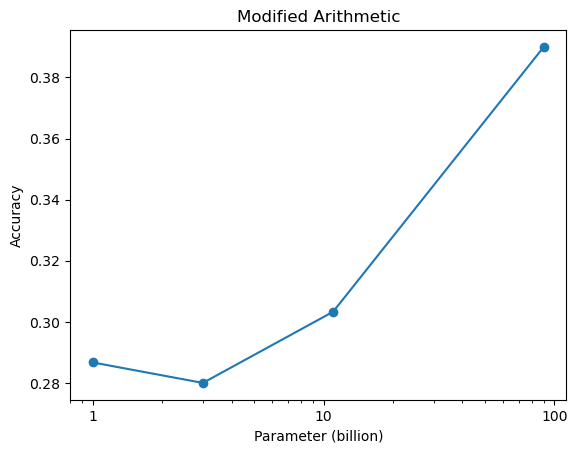

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.2867, 0.28, 0.3033, 0.39]

plt.plot(x, y, marker='o', linestyle='-', label='Modified Arithmetic')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("Modified Arithmetic")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.show()


### Testing on international_phonetic_alphabet_transliterate

In [83]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    # 'mixtral-8x22b-instruct',
    # 'mixtral-8x7b-instruct',
    # 'mistral-7b-instruct',
    # 'llama3.1-405b',
    # 'llama3.1-70b',
    # 'llama3.1-8b
]

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/international_phonetic_alphabet_transliterate/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset)

Evaluating model: llama3.2-90b-vision


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [02:02<00:00,  2.46s/it]


Evaluating model: llama3.2-11b-vision


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Evaluating model: llama3.2-3b


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Evaluating model: llama3.2-1b


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [86]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(results):
    total_bleu = 0
    total_count = len(results)

    for result in results:
        reference = [result['target'].split()]
        candidate = result['generated_text'].split()
        bleu_score = sentence_bleu(reference, candidate)
        total_bleu += bleu_score

    average_bleu = (total_bleu / total_count) * 100 if total_count > 0 else 0
    return average_bleu

# Calculate and print accuracy for each model
for model, results in all_results.items():
    accuracy = calculate_bleu(results)
    print(f"BLEU for {model}: {accuracy:.2f}%")

BLEU for llama3.2-90b-vision: 46.91%
BLEU for llama3.2-11b-vision: 9.67%
BLEU for llama3.2-3b: 9.79%
BLEU for llama3.2-1b: 2.92%


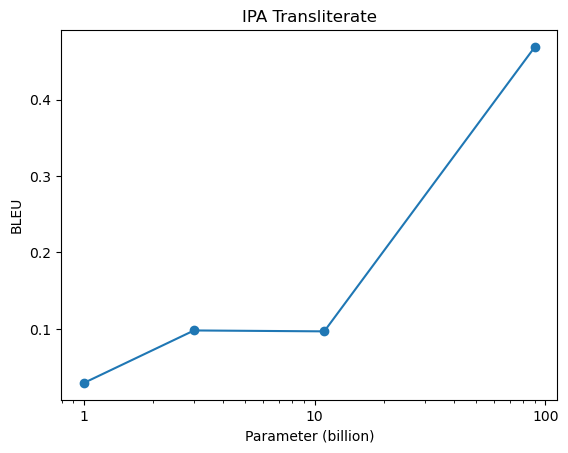

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.0292, 0.0979, 0.0967, 0.4691]

plt.plot(x, y, marker='o', linestyle='-')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("IPA Transliterate")
plt.xlabel("Parameter (billion)")
plt.ylabel("BLEU")
plt.show()

In [87]:
model_variants = [
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/international_phonetic_alphabet_transliterate/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset)
        
for model, results in all_results.items():
    accuracy = calculate_bleu(results)
    print(f"BLEU for {model}: {accuracy:.2f}%")

Evaluating model: mixtral-8x22b-instruct


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [01:59<00:00,  2.38s/it]


Evaluating model: mixtral-8x7b-instruct


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Evaluating model: mistral-7b-instruct


international_phonetic_alphabet_transliterate:  10%|█         | 5/50 [00:08<01:09,  1.54s/it]

Error occurred for model mistral-7b-instruct: Error code: 400 - {'detail': 'Failed to process your request. Please try again later. If you are processing a function, try using a larger model (70b) for better function formatting.'}


international_phonetic_alphabet_transliterate: 100%|██████████| 50/50 [01:27<00:00,  1.74s/it]

BLEU for mixtral-8x22b-instruct: 33.43%
BLEU for mixtral-8x7b-instruct: 5.41%
BLEU for mistral-7b-instruct: 4.51%


### Testing on word_unscrambling

In [ ]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    # 'mixtral-8x22b-instruct',
    # 'mixtral-8x7b-instruct',
    # 'mistral-7b-instruct',
]

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/word_unscrambling/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset, 200)

In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [100]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        # if result['prompt'] + " " + result['target'] in result['generated_text']:
        #     correct_count += 1
        # elif result['target'] == result['generated_text']:
        #     correct_count += 1
        # print(result)
        if isinstance(result['target'] , list):
            for target_word in result['target']:
                if target_word in result['generated_text']: 
                    correct_count += 1
                    break
        else:
            if result['target'] in result['generated_text']:
                correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 41.00%
Accuracy for llama3.2-11b-vision: 25.50%
Accuracy for llama3.2-3b: 11.50%
Accuracy for llama3.2-1b: 7.50%
Accuracy for mixtral-8x22b-instruct: 21.50%
Accuracy for mixtral-8x7b-instruct: 0.00%


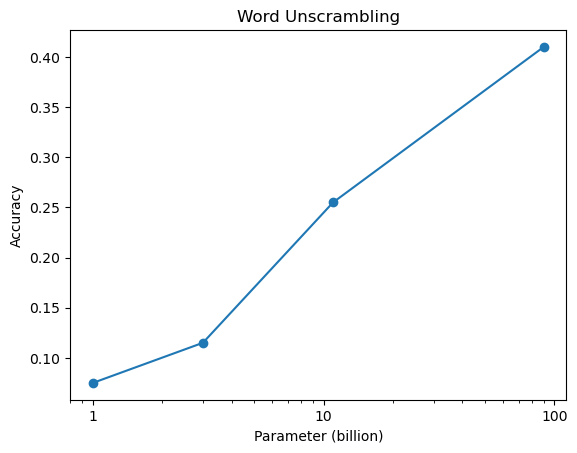

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.075, 0.115, 0.255, 0.41]

plt.plot(x, y, marker='o', linestyle='-')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("Word Unscrambling")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.show()

### Testing onc parsinlu_qa

In [117]:
model_variants = [
    'llama3.2-90b-vision',
    'llama3.2-11b-vision',
    'llama3.2-3b',
    'llama3.2-1b',
    'mixtral-8x22b-instruct',
    'mixtral-8x7b-instruct',
    'mistral-7b-instruct',
]
def evaluate_model(model_name, dataset, num_exp=50):
    # print(f"Evaluating model: {model_name}")
    results = []
    if 'examples' not in dataset:
        raise KeyError("The dataset does not contain the expected 'examples' key.")
    examples = random.sample(dataset['examples'], min(num_exp, len(dataset['examples'])))
    for example in tqdm(examples, desc=f"{dataset['name']}"):
        choices = list(example['target_scores'].keys())
        prompt = example['input'] + " choose from: " + ','.join(choices)
        target = example['target_scores']

        retry_count = 0
        while retry_count < 3:
            try:
                # Generate response using OpenAI client
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {
                            "role": "system",
                            "content": "Assistant is a large language model trained by OpenAI."
                        },
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ]
                )
                # print(response)
                try: 
                    generated_text = response.choices[0].message.content.strip()
                except:
                    generated_text = response[0]['message']['content'].strip() if isinstance(response, list) else response['choices'][0]['message']['content'].strip()
                # Store prompt, generated response, and target for analysis
                results.append({
                    'prompt': prompt,
                    'generated_text': generated_text,
                    'target': target
                })
                break
            except Exception as e:
                print(f"Error occurred for model {model_name}: {e}")
                retry_count += 1
                time.sleep(2)  # Wait before retrying
                if retry_count == 3:
                    print(f"Failed to get response after 3 attempts for prompt: {prompt}")
    return results

task_json_path = '/Users/shawna_song/Desktop/598tz_proj/BIG-bench/bigbench/benchmark_tasks/parsinlu_qa/task.json'

all_results = {}
for model in model_variants:
    print(f"Evaluating model: {model}")
    all_results[model] = []
    if os.path.isdir(task_path) and os.path.exists(task_json_path):
        with open(task_json_path, 'r') as f:
            bigbench_dataset = json.load(f)
        # print(f"Dataset structure for {task_name}:", json.dumps(bigbench_dataset, indent=2))
        # Evaluate each model variant and store results
        all_results[model] += evaluate_model(model, bigbench_dataset, 200)

Evaluating model: llama3.2-90b-vision


parsinlu_qa: 100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


Evaluating model: llama3.2-11b-vision


parsinlu_qa: 100%|██████████| 200/200 [04:41<00:00,  1.41s/it]


Evaluating model: llama3.2-3b


parsinlu_qa: 100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


Evaluating model: llama3.2-1b


parsinlu_qa: 100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


Evaluating model: mixtral-8x22b-instruct


parsinlu_qa: 100%|██████████| 200/200 [09:10<00:00,  2.75s/it]


Evaluating model: mixtral-8x7b-instruct


parsinlu_qa:  34%|███▍      | 69/200 [01:26<03:01,  1.38s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  39%|███▉      | 78/200 [01:44<02:43,  1.34s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  40%|███▉      | 79/200 [01:54<07:59,  3.97s/it]

Failed to get response after 3 attempts for prompt: علت عمده شکست جنبش مشروطه چه بود؟ choose from: مخالفت قدرت‌های غربی با نظام جدید,نارضایتی مردم از فقر و بیچارگی,کنار رفتن روحانیت از صحنه سیاست,هر سه مورد


parsinlu_qa:  40%|████      | 81/200 [01:56<05:06,  2.58s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  41%|████      | 82/200 [02:04<08:07,  4.13s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  42%|████▏     | 83/200 [02:14<11:08,  5.72s/it]

Failed to get response after 3 attempts for prompt: یک بشکه پر از بنزین است نصف آن خالی می‌شود. چند درصد گنجایش شبکه بنزین ندارد؟ choose from: ۶۶/۶ درصد,۳۳/۳ درصد,۵۰ درصد,هیچ کدام
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  42%|████▏     | 84/200 [02:24<13:29,  6.98s/it]

Failed to get response after 3 attempts for prompt: وسیع‌ترین دریاچه جهان در کدام قاره قرار دارد؟ choose from: آمریکا,اروپا,آسیا,آفریقا
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  42%|████▎     | 85/200 [02:33<14:50,  7.74s/it]

Failed to get response after 3 attempts for prompt: کدام عدد بعد از این سری باید بیاید؟ 25 - 24 - 22 - 19 - 15 - ؟ choose from: 10,9,11,
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  43%|████▎     | 86/200 [02:43<15:46,  8.31s/it]

Failed to get response after 3 attempts for prompt: موتورسواری با سرعت متوسط ۶۰ کیلومتر در ساعت فاصله بین دو شهر را طی می‌کند و همین فاصله را با
سرعت متوسط ۴۰ کیلومتر در ساعت برمی گردد. سرعت متوسط او برای تمام مسیر رفت و برگشت عبارت
 choose from: ۵۳ کیلومتر در ساعت,۵۰ کیلومتر در ساعت,۴۸ کیلومتر در ساعت,۵۲ کیلومتر در ساعت
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable
Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  51%|█████     | 102/200 [03:25<03:46,  2.32s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  52%|█████▏    | 103/200 [03:32<05:32,  3.43s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa:  52%|█████▎    | 105/200 [03:40<05:47,  3.66s/it]

Error occurred for model mixtral-8x7b-instruct: 'ChatCompletion' object is not subscriptable


parsinlu_qa: 100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


Evaluating model: mistral-7b-instruct


parsinlu_qa: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


In [ ]:
# Print the results for analysis
for model, results in all_results.items():
    print(f"\nResults for {model}:")
    for result in results:
        print(f"Prompt: {result['prompt']}")
        print(f"Generated: {result['generated_text']}")
        print(f"Target: {result['target']}\n")

In [118]:
def calculate_accuracy(results):
    correct_count = 0
    total_count = len(results)

    for result in results:
        for choice in result['target'].keys():
            if result['target'][choice] == 1:
                if str(result['target'][choice]) in result['generated_text']:
                    correct_count += 1

    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    return accuracy

for model, results in all_results.items():
    accuracy = calculate_accuracy(results)
    print(f"Accuracy for {model}: {accuracy:.2f}%")

Accuracy for llama3.2-90b-vision: 13.00%
Accuracy for llama3.2-11b-vision: 17.00%
Accuracy for llama3.2-3b: 17.00%
Accuracy for llama3.2-1b: 10.50%
Accuracy for mixtral-8x22b-instruct: 30.00%
Accuracy for mixtral-8x7b-instruct: 36.41%
Accuracy for mistral-7b-instruct: 32.50%


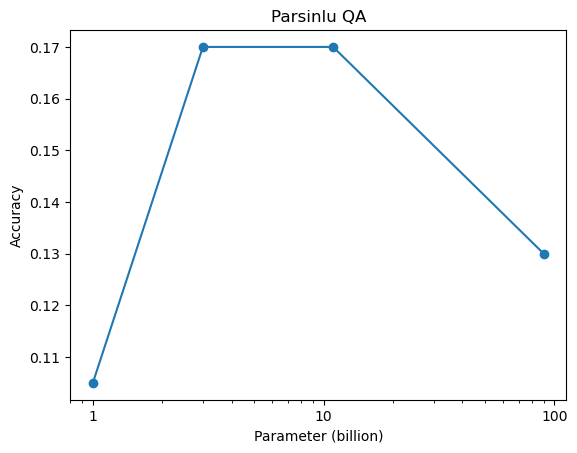

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatter, LogLocator

x = np.array([1, 3, 11, 90]) 
y = [0.105, 0.17, 0.17, 0.13]

plt.plot(x, y, marker='o', linestyle='-')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=True))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
plt.title("Parsinlu QA")
plt.xlabel("Parameter (billion)")
plt.ylabel("Accuracy")
plt.show()